In [12]:

import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt


failure_data = pd.read_csv(r'Failure_modelling\Failure_Data\failure_data.csv', index_col=0)
pipe_data = pd.read_csv(r'Failure_modelling\Failure_Data\pipe_data.csv', index_col=0)

In [13]:
ac_pipes = pipe_data[pipe_data.Materiaalcode == 'MAT_AC']
ac_failures = failure_data[failure_data.storing_materiaal == 'MAT_AC']
model_failures = ac_failures[['storing_materiaal', 'storing_diameter', 'storing_melddatum', 'storing_aanlegjaar', 'age_at_failure']].copy()
model_failures.loc[:,'age_at_failure'] = model_failures.loc[:,'age_at_failure'].astype(int)
model_pipes = ac_pipes[['Aanlegjaar', 'Lengte', 'Diameter', 'Materiaalcode']].copy()
model_pipes = model_pipes[model_pipes.Aanlegjaar > 1]

In [14]:
diameter_groups = [[0, 160],
                   [160, 300],
                   [300, 1000],
                   [1000, 10000]]

construction_year_groups = []
for i in range(1920, 2000 + 1, 10):
    construction_year_groups.append([i, i+10])

model_pipes['Diameter_group'] = None
model_failures['Diameter_group'] = None
model_pipes['Construction_year_group'] = None
model_failures['Construction_year_group'] = None
model_pipes['Group_id'] = None
model_failures['Group_id'] = None

for diameter_group in diameter_groups:
    diameter_mask_failures = (model_failures.storing_diameter >= diameter_group[0]) & (model_failures.storing_diameter < diameter_group[1])
    model_failures.loc[diameter_mask_failures, 'Diameter_group'] = f'{diameter_group[0]} - {diameter_group[1]}'
    
    diameter_mask_pipes = (model_pipes.Diameter >= diameter_group[0]) & (model_pipes.Diameter < diameter_group[1])
    model_pipes.loc[diameter_mask_pipes, 'Diameter_group'] = f'{diameter_group[0]} - {diameter_group[1]}'

    for construction_year_group in construction_year_groups:
        construction_year_mask_failures = (pd.to_datetime(model_failures.storing_aanlegjaar, format='%Y-%m-%d').dt.year>= construction_year_group[0]) & (pd.to_datetime(model_failures.storing_aanlegjaar, format='%Y-%m-%d').dt.year < construction_year_group[1])
        model_failures.loc[construction_year_mask_failures, 'Construction_year_group'] = f'{construction_year_group[0]} - {construction_year_group[1]}'
        
        model_failures.loc[(diameter_mask_failures & construction_year_mask_failures), 'Group_id'] = int(f'{diameter_group[0]}{diameter_group[1]}{construction_year_group[0]}{construction_year_group[1]}')
        
        construction_year_mask_pipes = (pd.to_datetime(model_pipes.Aanlegjaar, format='%Y').dt.year >= construction_year_group[0]) & (pd.to_datetime(model_pipes.Aanlegjaar, format='%Y').dt.year < construction_year_group[1])
        model_pipes.loc[construction_year_mask_pipes, 'Construction_year_group'] = f'{construction_year_group[0]} - {construction_year_group[1]}'
        
        model_pipes.loc[(diameter_mask_pipes & construction_year_mask_pipes), 'Group_id'] = int(f'{diameter_group[0]}{diameter_group[1]}{construction_year_group[0]}{construction_year_group[1]}')

        
common_group_ids = set(model_pipes['Group_id'].dropna()) & set(model_failures['Group_id'].dropna())


model_pipes = model_pipes[model_pipes['Group_id'].isin(common_group_ids)]
model_failures = model_failures[model_failures['Group_id'].isin(common_group_ids)]


group_length = model_pipes.groupby('Group_id')['Lengte'].sum() / 1000
group_failure_count = model_failures.groupby('Group_id')['storing_materiaal'].count()

group_stats = pd.DataFrame({
    'Total_Length': group_length,
    'Failure_Count': group_failure_count
})

group_stats['Failure_Rate'] = group_stats['Failure_Count'] / group_stats['Total_Length'] / 10

model_failures['Group_failurerate'] = model_failures['Group_id'].map(group_stats['Failure_Rate'])

model_failures['Group_failurerate'].fillna(0, inplace=True)


group_length = model_pipes.groupby('Diameter_group')['Lengte'].sum() / 1000
group_failure_count = model_failures.groupby('Diameter_group')['storing_materiaal'].count()
group_stats = pd.DataFrame({
    'Total_Length': group_length,
    'Failure_Count': group_failure_count
})

group_stats['Failure_Rate'] = group_stats['Failure_Count'] / group_stats['Total_Length'] / 10

model_failures['Diameter_group_failurerate'] = model_failures['Diameter_group'].map(group_stats['Failure_Rate'])

model_failures['Diameter_group_failurerate'].fillna(0, inplace=True)

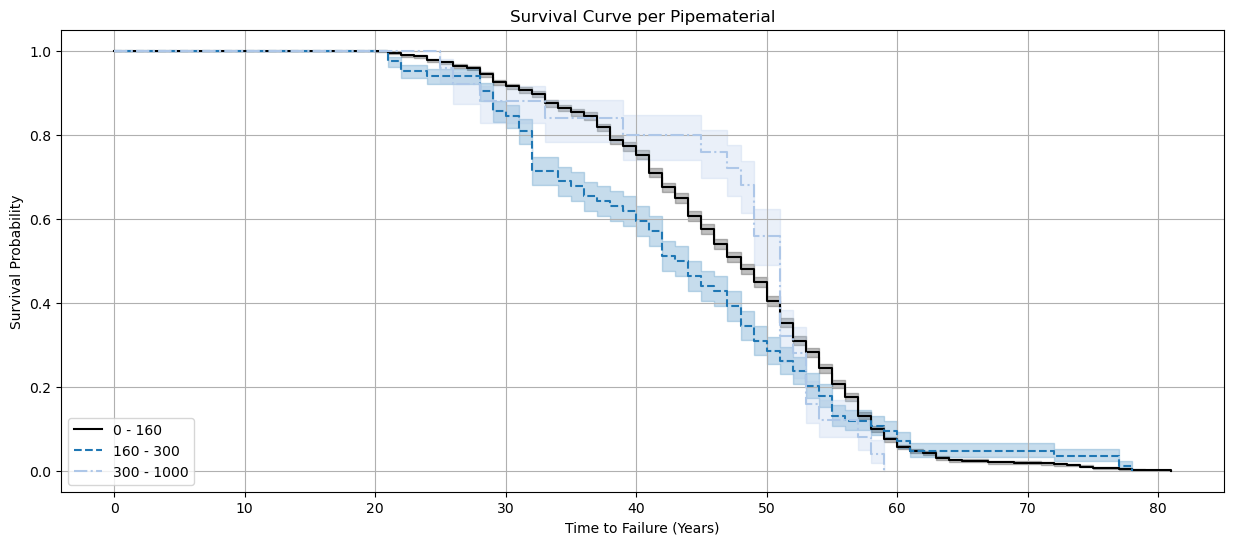

In [15]:
from lifelines import KaplanMeierFitter
from itertools import cycle

kmf = KaplanMeierFitter()

# Define colors and line styles
colors = [
    '#000000',  # Black
    '#1f77b4',  # Blue
    '#aec7e8',  # Light Blue
    '#17becf',  # Cyan
    '#9edae5',  # Light Cyan
    '#2ca02c',  # Green
    '#98df8a',  # Light Green
    '#bcbd22',  # Olive
    '#ffbb78',  # Light Orange
    '#ff7f0e',  # Orange
    '#d62728',  # Red
    '#ff9896',  # Light Red
    '#e377c2',  # Pink
    '#9467bd',  # Purple
    '#c5b0d5',  # Light Purple
    '#8c564b',  # Brown
    '#7f7f7f'   # Gray
]

line_styles = ['-', '--', '-.', ':']

# Create a cycle iterator for both colors and line styles
color_cycle = cycle(colors)
line_style_cycle = cycle(line_styles)
plt.figure(figsize=(15,6))
for i, (material, group) in enumerate(model_failures.groupby('Diameter_group')):
    kmf.fit(group['age_at_failure'], event_observed=(group['storing_melddatum'].notnull()), label=material, alpha=0.5)
    color = next(color_cycle)
    line_style = next(line_style_cycle)
    kmf.plot(color=color, linestyle=line_style, label=material)
plt.title('Survival Curve per Pipematerial')
plt.xlabel('Time to Failure (Years)')
plt.ylabel('Survival Probability')
plt.grid()
plt.legend(loc=3)
plt.show()

In [16]:
from sklearn.model_selection import train_test_split

failures_train, failures_test = train_test_split(model_failures, test_size=0.2, random_state=42)
pipes_train, pipes_test = train_test_split(model_pipes, test_size=0.2, random_state=42)

failures_test.to_csv('Failure_modelling/Failure_data/failure_test.csv')
failures_train.to_csv('Failure_modelling/Failure_data/failure_train.csv')
pipes_test.to_csv('Failure_modelling/Failure_data/pipes_test.csv')
pipes_train.to_csv('Failure_modelling/Failure_data/pipes_train.csv')